In [ ]:
import os, sys
import gsflow
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import pandas as pd
import matplotlib.patheffects as path_effects

from conda_scripts import arich_functions
import conda_scripts.owhm as owhm
import conda_scripts.plot_help as plot_help
import conda_scripts

import conda_scripts.rich_gis as rg
import conda_scripts.plot_help as ph

import plotly.express as px
import cartopy.crs as ccrs 
import contextily as ctx
import xarray as xr
import adjustText
import textwrap

plt.rcParams['figure.figsize'] = (6, 6)
import post_process as pp
import pretty_maps
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
from osgeo import gdal
from osgeo import osr
from osgeo import ogr

In [ ]:
basin = 'PET'
year = 2023

In [ ]:
mod = pp.wl_ch(basin)

In [ ]:
mod.load_ml()

In [ ]:
def describe_obs(mod):
    df = pd.read_csv(os.path.join(r"C:\GSP\waterlevel\regression_data",f"{mod.basin.upper()}_seas_info.csv"))
    print(df.shape)
    c= df.loc[:,'Station Name'].str.contains('mod')
    df.loc[:,'model'] = 0
    df.loc[c,'model'] = 1
    # desc = df.describe()
    desc =df.loc[:,'model'].sum()
    
    datespan = df.loc[~c,'date_frac'].describe().loc[['min','max']]
    print(f'these are the spans of observed data {datespan.values}')
    
    datespan = df.loc[c,'date_frac'].describe().loc[['min','max']]
    print(f'these are the spans of modeled data {datespan.values}')
    
    datespan = df.loc[~c,'date_frac'].describe().loc[['count']]
    print(f'these are the number of observed data {datespan.values}')
    
    datespan = df.loc[c,'date_frac'].describe().loc[['count']]
    print(f'these are the number of modeled data {datespan.values}')
    return desc, datespan
    
describe_obs(mod)
    

In [ ]:
print('checking for missing wl years')
miss = 0
for depth in ['Shallow', 'Deep']:
    for season in ['Spring','Fall']:
        for file in [f"wl_change_predictions_{depth}_{season}.netcdf",f"wl_predictions_{depth}_{season}.netcdf"]:
            path = os.path.join(mod.folder,file)
            wlmap = xr.open_dataset(path)

            if ~(wlmap.year.to_series().diff().dropna().unique()==1.).all():
                import warnings
                miss = miss+1
                warnings.warn('There are gaps in wl prediction years in the netcdf')
            wlmap.close()
            
print(f'there are {miss} missing years in netcdfs')

In [ ]:
def write_tif_from_xarray(grid, filename, fmt):
    offset = np.abs(grid.easting.values[1] - grid.easting.values[0])/2
    # print(f"the spatial offset values is {offset}")
    conda_scripts.rich_gis.write_acsii(np.flipud(grid),
                         grid.easting.values-offset, grid.northing.values-offset, -999,
                         filename, fmt=fmt)
    print(f'done writing tiff to\n{filename}')
    


# plot waterlevel change

In [ ]:
year = 2023
fignums = {'SON':{'SON':{'Fall':"Figure 3-7",},
                      'Shallow':{'Fall':"Figure 3-8",}},
               'SRP':{'Deep':{'Fall':"Figure 3-7",},
                      'Shallow':{'Fall':"Figure 3-8",}},
              'PET':{'Deep':{'Fall':"erase",},
                      'Shallow':{'Fall':"Figure 3-5", }}}
                      
                      
fig_title = {'SON':{'Deep':{'Spring':None,'Fall':None,},
                  'Shallow':{'Spring':None,'Fall':None}},
           'SRP':{'Deep':{'Spring':None,'Fall':None,},
                  'Shallow':{'Spring':None,'Fall':None}},
          'PET':{'Deep':{'Fall':f"Groundwater-Level Change, Fall {year-1}-{year}"},
                  'Shallow':{'Fall':f"Groundwater-Level Change, Fall {year-1}-{year}"}}}
    
for depth in ['Shallow', 'Deep']:
    for season in [ 'Fall']:
        pretty_maps.plot_year_diff(basin,year=year,depth=depth, season = season,
                                   datafolder=mod.folder,
                                   figure_num=fignums[basin][depth][season],
                                   out_folder=mod.share_folder,
                                   title=fig_title[basin][depth][season])

In [ ]:
# for depth in ['Shallow', 'Deep']:
#     for season in ['spring', 'fall']:
#         path = os.path.join(mod.folder,f"wl_change_predictions_{depth}_{season}.netcdf")

#         wlmap = xr.open_dataset(path)

#         levels = [-20,-15,-10,-5,-1,1,5,10,15,20]

#         fig = plt.figure(figsize = (10,10), dpi = 250)
#         year = 2023
#         title = f"Waterlevel Changes from {year-1} to {year}, {depth.capitalize()} Aquifer, {season.capitalize()}"
#         mm = conda_scripts.make_map.make_map(title)

#         ax = mm.plotloc(fig, locname = basin, maptype = 'ctx.OpenStreetMap.Mapnik')

#         c = wlmap.sel(year =year)

#         mask = pp.get_mask(basin)
#         c.where(mask).Head.plot.contourf(ax = ax, alpha = .7, extend = 'both', levels = levels, cmap = 'RdYlBu', 
#                                          cbar_kwargs ={'label':'Change in Waterlevel between Years (feet)\nnegative values denote decline',
#                                                       'shrink':.5} )
#         c.where(mask).Head.plot.contour(ax = ax, color = 'k',colors='k', linewidths=.5, linestyles='solid', levels = levels)
#         ax.set_title(title)

#         # conda_scripts.arich_functions.add_basemaps(ax, 'transpo',False)

#         # arich_functions.add_basemap_hydro(ax)
#         plt.savefig(os.path.join(mod.share_folder, f'WL change {depth}_{season}.png'), dpi = 250)
        
#         tifpath = os.path.join(mod.folder,f"wlch_{year}_{depth}_{season}.tif")
#         write_tif_from_xarray(c.where(mask).Head, tifpath, fmt='%.3f',)


# plot gw storage change MAPS

In [ ]:
fignums = {'son':{'SON':{'Fall':"Figure 3-12",},
                      'Shallow':{'Fall':"Figure 3-11",}},
               'SRP':{'Deep':{'Fall':"Figure 3-12",},
                      'Shallow':{'Fall':"Figure 3-11",}},
              'PET':{'Deep':{'Fall':"erase",},
                      'Shallow':{'Fall':"Figure 3-8", }}}
                      
                      
fig_title = {'SON':{'Deep':{'Spring':None,'Fall':None,},
                  'Shallow':{'Spring':None,'Fall':None}},
           'SRP':{'Deep':{'Spring':None,'Fall':None,},
                  'Shallow':{'Spring':None,'Fall':None}},
          'PET':{'Deep':{'Fall':f"Change in Groundwater Storage, Fall {year-1}-{year}"},
                  'Shallow':{'Fall':f"Change in Groundwater Storage, Fall {year-1}-{year}"}}}
    
for depth in ['Shallow', 'Deep']:
    for season in [ 'Fall']:
        pretty_maps.plot_year_storage_change(basin,year=year,depth=depth, season = season,
                                   datafolder=mod.folder,
                                   figure_num=fignums[basin][depth][season],
                                   out_folder=mod.share_folder,
                                   title=fig_title[basin][depth][season],
                                            mod = mod)


In [ ]:
os.getcwd()

In [ ]:
seasinfo =  conda_scripts.utils.load_all_gw_wiski.load_all_gw(download = False,
                                             outfolder = 'C:\\GSP\\waterlevel\\regression_data',
                                             filter_manual= True,
                                                         outfile='all_gw_for_surf_2024_01_23.csv')

In [ ]:
def load_obs(mod, year):
    f = os.path.join(mod.folder.replace('maps','hydros'),f'seasinfo_w_predicted_{mod.basin.upper()}.csv')
    tab = pd.read_csv(f, usecols = ['Station Name',	'Manual Measurement',	'Timestamp','Depth_Reclass'])
    
    tab = tab.loc[~tab.loc[:,'Station Name'].str.startswith('r')].sort_values('Timestamp')
    
    tab.loc[:,'Timestamp'] = pd.to_datetime(tab.loc[:,'Timestamp'],format = 'mixed')
    print(tab.head())
    print(tab.isnull().sum())
    print(tab.dtypes)
    tab = tab.loc[pd.to_datetime(tab.Timestamp).dt.year==year]
    # tab.loc[:,'Month'] = tab.loc[:,'Timestamp'].dt.month
    tab.loc[:,'Month'] = pd.to_datetime(tab.Timestamp).dt.month
    tab.loc[:,'Month'] = tab.loc[:,'Month'].astype(str)
    tab = tab.groupby(['Station Name','Depth_Reclass'])['Month'].apply(','.join).reset_index()


    gw_stats = conda_scripts.wiski.wiski.get_gw_stations_wellmeta_in_basin(
        basins = [f"{mod.basin.upper().replace('SON','Son')}*"])
    
    obsinfo = pd.merge(tab, gw_stats.loc[:,:'station_longitude'],
             left_on = 'Station Name', right_on = 'station_name')

    obsinfo = gpd.GeoDataFrame(obsinfo, 
                               geometry = gpd.points_from_xy(obsinfo.station_longitude, 
                                                             obsinfo.station_latitude),
                               crs = 4326
                              ).to_crs(2226)    
    
    return obsinfo



In [ ]:
# from project2d import label_points
# def plot_year(basin, year, depth, out_folder, obs, plot_obs = False):

#     '''
#     create pretty maps of waterlevel estimates
#     :param basin: srp/son/pet
#     :param year: int
#     :param depth: Shallow/Deep
#     :param out_folder: where the final figures will go
#     :param plot_obs: if False will plot all monthly obs. if true will just plot station name
#     :return: None
#     '''

#     fig = plt.figure(figsize=(6, 8), dpi=250)
#     gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])
#     ax = fig.add_subplot(gs[0:2, :], projection=ccrs.epsg(2226))
#     conda_scripts.rich_gis.set_extent(ax, locname=basin)

#     title = f"Waterlevel for {depth.capitalize()} Aquifer, {year}"
    
#     obs.query(f"Depth_Reclass=='{depth}'").plot(ax=ax, edgecolor='k', markersize=15, facecolor = 'purple')
    
#     if plot_obs:
#         col2plot = 'station_name'
#         maptype = 'station_names'
#     else:
#         col2plot = 'Month'
#         maptype = 'monthly_obs'
        
#     already_str = True
#     label_points(ax, obs.query(f"Depth_Reclass=='{depth}'"), col2plot,
#                  basin_name=[basin.upper()],
#                  buffer=20000, limit=5, already_str=already_str)


#     ctx.add_basemap(ax, source="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", crs=2226)
#     ax.set_title(title, fontsize=12)
    
#     plt.savefig(os.path.join(mod.share_folder, f'GW {maptype} {depth} {year} map.png'), dpi = 250)
    


In [ ]:
pd.__version__

In [ ]:
datafolder = None
out_folder = mod.out_folder
yearplot = 2023
obsinfo = load_obs(mod, yearplot)


[[plot_year(mod.basin, yearplot, shallow,  out_folder, obsinfo, plot_obs = wellobs)
                for shallow in ('Shallow', 'Deep')] for wellobs in [True, False]]



In [ ]:
import rioxarray

# plot pretty maps of waterlevels for basin/depth/season

In [ ]:
# this is done via the pretty_maps script

In [ ]:
#     fignums = {'son':{'Deep':"Figure 3-7",'Shallow':"Figure 3-8"},
#                'srp':{'Deep':"Figure 3-7",'Shallow':"Figure 3-8"},
#                'pet':{'Deep':"Figure 3-7",'Shallow':"Figure 3-8"}}

# [[pretty_maps.plot_year(mod.basin, year,  shallow, season,fignums[basin.lower()][shallow],mod.folder, mod.share_folder) 
#   for shallow in ('Shallow', 'Deep')] 
#  for season in ('Fall', 'Spring')]

In [ ]:
dfall, stor_ch_dict = mod.load_hist()

In [ ]:
def combine_aquifers(fic, season):
    fic = fic.filter(regex = season).loc['2012':,].sum(axis=1).to_frame('Storage Change (af)')
    
    fic.columns = pd.MultiIndex.from_product([[season], fic.columns, ])

    
    return fic

combine_aquifers(dfall, 'Spring')
    

In [ ]:
formatter = lambda x:'{:^8s}'.format("{:,d}".format(int(np.round(x / 10.0)) * 10))

dfall, stor_ch_dict = mod.load_hist()

dfall.to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years.xlsx'))

if mod.basin=='pet':
    print('combining for petaluma')
    combine_aquifers(dfall, 'Spring').applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_spring.xlsx'))
    combine_aquifers(dfall, 'Fall').applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_fall.xlsx'))
    combine_aquifers(dfall, 'Spring').applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_spring.xlsx'))
    combine_aquifers(dfall, 'Fall').applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_fall.xlsx'))

    # dfall.filter(regex = 'Spring').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_spring.xlsx'))
    # dfall.filter(regex = 'Fall').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_fall.xlsx'))
    # dfall.filter(regex = 'Spring').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_spring.xlsx'))
    # dfall.filter(regex = 'Fall').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_fall.xlsx'))
else:
    dfall.filter(regex = 'Spring').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_spring.xlsx'))
    dfall.filter(regex = 'Fall').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.out_folder, 'Storage_change_all_years_report_fall.xlsx'))
    dfall.filter(regex = 'Spring').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_spring.xlsx'))
    dfall.filter(regex = 'Fall').loc['2012':,].applymap(formatter).to_excel(os.path.join(mod.share_folder, 'Storage_change_all_years_report_fall.xlsx'))

In [ ]:
np.linspace(-.0075, .0075, 7)

In [ ]:
np.linspace(-.6, .6, 7)

In [ ]:
np.arange(-0.6, .61, .2)

In [ ]:
year = 2023

def get_cell_area(wl):
    dh = wl.easting.diff(dim='easting').data[0]
    dy = wl.northing.diff(dim='northing').data[0]
    cell_area = dh * dy
    
    return cell_area

for depth in ['Shallow', 'Deep']:
    for season in ['Spring', 'Fall']:
        storch_xr = stor_ch_dict[f'{depth}, {season}']

        #     path = os.path.join(mod.folder,f"wl_change_predictions_{depth}_Spring.netcdf")

        #     wlmap = xr.open_dataset(path)

        fig = plt.figure(figsize = (10,10), dpi = 250)
        
        
        mm = conda_scripts.make_map.make_map(title)

        levels = None


        ax = mm.plotloc(fig, locname = basin, maptype = 'ctx.OpenStreetMap.Mapnik')
        mask = pp.get_mask(basin)
        # get year
        c = storch_xr.sel(year =year)
        # get cell area
        cell_area = get_cell_area(c)
        #convert storage change from ft^3 per cell, to ft^3 per ft
        c = c.where(mask).Head/cell_area
        label = 'Change in Groundwater Storage Due to Groundwter Elevation Changes, in acre-feet per acre'
        label = '\n'.join(textwrap.wrap(label,30))
        
        c.plot.contourf(ax = ax, alpha = .7, extend = 'both',  cmap = 'RdYlBu', levels = levels, 
                                         cbar_kwargs ={'label':label,
                                                      'shrink':.5} )
        c.plot.contour(ax = ax, color = 'k',colors='k', linewidths=.5, linestyles='solid', levels = levels)
        title = f"Groundwater Storage Changes from {year-1} to {year}, {season}, {depth.capitalize()} Aquifer"

        title = '\n'.join(textwrap.wrap(title,30))
        # title = f"Waterlevel Changes from {year-1} to {year}, {depth.capitalize()} Aquifer"
        ax.set_title(title)

        # conda_scripts.arich_functions.add_basemaps(ax, 'transpo',False)

        # arich_functions.add_basemap_hydro(ax)
        plt.savefig(os.path.join(mod.share_folder, f'GW change {depth} {season} {year} map.png'), dpi = 250)
        
        tifpath = os.path.join(mod.folder,f"storch_{year}_{depth}_{season}.tif")
        write_tif_from_xarray(c.where(mask), tifpath, fmt='%.8f',)

In [ ]:
fig, (ax1, ax2 ) = plt.subplots(1,2,figsize = (10,5))
plt.subplots_adjust(wspace = 0.5)
ax1.set_title('Deep')
ax1.set_ylabel('Yearly storage change')
ax1.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_title('Shallow')
dfall.droplevel(1,axis=1).filter(regex = 'Deep').plot.bar(ax = ax1)
axi = ax1.twinx()

dfall.droplevel(1,axis=1).filter(regex = 'Deep').rename({i:x for x,i in enumerate(dfall.index)}).cumsum().plot(ax =axi)
axi.legend().remove()

axi.tick_params(axis='y', labelcolor='b')

dfall.droplevel(1,axis=1).filter(regex = 'Shal').plot.bar(ax = ax2)
axi = ax2.twinx()
dfall.droplevel(1,axis=1).filter(regex = 'Shal').rename({i:x for x,i in enumerate(dfall.index)}).cumsum().plot(ax =axi)
axi.legend().remove()
axi.set_ylabel('cumulative storage change')
axi.tick_params(axis='y', labelcolor='b')

ph.relabel_bar(ax1)
ph.relabel_bar(ax2)

plt.suptitle('Year over Year storage change')

plt.savefig(os.path.join(mod.out_folder, f"storage change comp.png"))

In [ ]:
def plot_bars(df, ax, fig, query, wetleg = False):
    
    cc = df.loc['2012':,].droplevel(1,axis=1).filter(regex = query).set_index(
        pd.to_datetime(df.loc['2012':,].index, format = '%Y'))
    
    ph.stackedbar_wdates(cc,ax = ax, fig = fig, remove_wet_dry=wetleg)
    
    ax.legend().remove()
    

In [ ]:
for _seas in ['Fall', 'Spring']:
    fig, (ax1, ax2 ) = plt.subplots(1,2,figsize = (10,5))
    
    # ppw.plot_hist(fig = fig, ax = ax1)
    # ppw.plot_hist(fig = fig, ax = ax2)
    
    
    c = 'k'
    fc = 'b'
    plt.subplots_adjust(wspace = 0.5)
    ax1.set_title('Deep Aquifer')
    ax1.set_ylabel('Yearly storage change (acre-feet)')
    ax2.set_ylabel('Yearly storage change (acre-feet)')
    ax1.tick_params(axis='y', labelcolor=c)
    ax2.tick_params(axis='y', labelcolor=c)


    ax2.set_title('Shallow  Aquifer')
    # dfall.loc['2012':,].droplevel(1,axis=1).filter(
    #     regex = f"(Deep).+({_seas})").plot.bar(ax = ax1, facecolor = fc)
    # dfall.loc['2012':,].droplevel(1,axis=1).filter(
    #     regex = f"(Shallo).+({_seas})").plot.bar(ax = ax2, facecolor =fc)
    
    plot_bars(dfall, ax1, fig, query = f"(Deep).+({_seas})",wetleg = True)
    plot_bars(dfall, ax2, fig, query = f"(Shallo).+({_seas})",wetleg = False)

    ax1.grid(True)
    ax2.grid(True)
    # hide the spines between ax and ax2
    # ax1.spines['right'].set_visible(False)
    # ax1.spines['top'].set_visible(False)
    # ax2.spines['right'].set_visible(False)
    # ax2.spines['top'].set_visible(False)

    plt.suptitle(f'{_seas} Year-to-Year storage change')

    plt.savefig(os.path.join(mod.out_folder, f"storage change {_seas} yearly.png"),dpi = 300)
    plt.savefig(os.path.join(mod.share_folder, f"storage change {_seas} yearly.png"), dpi = 300)

# get the simulated storage change data by layer

In [ ]:
from conda_scripts.utils import GSP_budget

In [ ]:
if basin == 'SRP':

    hist = pd.read_csv('srphm_layer_storage_change.csv')
    hist = hist.set_index('wy')
    hist.index = pd.to_datetime(hist.index).year

    hist = hist.loc[:,['lay1','lay2','lay3','lay4']]
    hist.head()
    
elif basin.upper() == 'SON':
    
    # total_stor , curr = conda_scripts.arich_functions.read_desc_trans(r'C:\GSP\sv\budget\SV_bud_output',
    #                                              'SV_GWOUTFLOWS_INFLOWS_storchange.xlsx')
    total_stor , curr = GSP_budget.read_desc(r'C:\GSP\sv\budget\SV_bud_output',
                                             'SV_GWOUTFLOWS_INFLOWS_storchange.xlsx')
    # total_stor.index = total_stor.index.year
    
    hist = pd.read_csv('sv_layer_storage_change.csv', index_col=[0])
    # hist = hist.set_index('wy')
    hist.index = pd.to_datetime(hist.index).year

    hist = hist.filter(regex = 'layer')
    
    
    hist.columns = ['lay1', 'lay2', 'lay3', 'lay4', 'lay5', 'lay6']
    
elif basin.lower() == 'pet':
    
    if 'hist' in locals():
        del hist
    total_stor , curr = GSP_budget.read_desc_trans(r'C:\GSP\petaluma\model_budget\PV_bud_output_V3_LU_update',
                                                 'Cum_stor_change.xlsx')
    total_stor.index = total_stor.index.year
    
    
    fff = os.path.join(r'c:/GSP/petaluma/model_budget/PV_bud_output_V3_LU_update',"Cum_stor_change_by_layer.xlsx")
    
    hist = pd.read_csv(fff, index_col=[0])
    # hist = hist.set_index('wy')
    hist.index = pd.to_datetime(hist.index).year

    hist = hist.filter(regex = 'lay')
    
    hist.columns = ['lay1', 'lay2', 'lay3', 'lay4', 'lay5']
    
    
else:
    raise ValueError(f"not implemented {basin}")
    
    
if 'hist' in list(locals().keys()):
    print(hist.head())
    



# move files to share folder

In [ ]:
#create polygons and polylines of contours
def write_poly(file, outfile, contour = 100):
    indataset1 = gdal.Open(file, gdal.GA_ReadOnly)
    intervals = list(np.arange(-500,2000,contour))

    sr = osr.SpatialReference(indataset1.GetProjection())
    
    ogr_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(outfile)
    ogr_lyr = ogr_ds.CreateLayer('contour' , sr , geom_type=ogr.wkbMultiPolygon)
    field_defn = ogr.FieldDefn('ID', ogr.OFTInteger)
    ogr_lyr.CreateField(field_defn)
    field_defn = ogr.FieldDefn('elevMin', ogr.OFTReal)
    ogr_lyr.CreateField(field_defn)
    field_defn = ogr.FieldDefn('elevMax', ogr.OFTReal)
    ogr_lyr.CreateField(field_defn)

    # ds = gdal.Open('tmp/gdal_contour.tif')
    ds = gdal.Open(file, gdal.GA_ReadOnly)
    #gdal.ContourGenerateEx(ds.GetRasterBand(1), 0, 0, 0, [10, 20, 25], 0, 0, ogr_lyr, 0, 1, 1)
    lev = "FIXED_LEVELS="+','.join([str(x) for x in intervals])
    lev
    gdal.ContourGenerateEx(ds.GetRasterBand(1), ogr_lyr, 
                           options = [ lev,#"FIXED_LEVELS=10,20,25",
                                     "ID_FIELD=0",
                                     "ELEV_FIELD_MIN=1",
                                     "ELEV_FIELD_MAX=2",
                                     "POLYGONIZE=TRUE" ] )
    ogr_ds = None
    del ogr_ds
    del indataset1
    

def write_lines(file, outfile, contour = 100):
    indataset1 = gdal.Open(file, gdal.GA_ReadOnly)
    in1 = indataset1.GetRasterBand(1)

    # name = 'test1.shp'
    sr = osr.SpatialReference(indataset1.GetProjection())
    ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(outfile)
    ogr_lyr = ogr_ds.CreateLayer('contour', sr)

    field_defn = ogr.FieldDefn('ID', ogr.OFTInteger)
    ogr_lyr.CreateField(field_defn)
    field_defn = ogr.FieldDefn('elev', ogr.OFTReal)
    ogr_lyr.CreateField(field_defn)

    intervals = list(np.arange(-500,1000,contour))

    #Generate Contourlines - ContourGenerate from https://gdal.org/python/osgeo.gdal-module.html#ContourGenerate
    gdal.ContourGenerate(
        in1,    #Band srcBand
        0,      #double contourInterval - This defines contour intervals
        0,      #double contourBase
        intervals,      #int fixedLevelCount
        0,      #int useNoData
        0,      #double noDataValue
        ogr_lyr, #Layer dstLayer
        0,      #int idField
        1       #int elevField
        )
    #ogr_ds.Destroy() - Better not to use this method. See here: https://gdal.org/api/python_gotchas.html
    #instead, empty and delete the dataframe
    ogr_ds = None
    del ogr_ds
    del indataset1

In [ ]:
allfiles = os.listdir(mod.folder)

#filter by these names
years = '2022|2023'
season = 'spring|fall'
cntr = 'cnt|cont'

allfiles = [x for x in allfiles if ((re.search(years, x.lower()) is not None) 
                                    and (re.search(season, x.lower()) is not None)) 
                                    and (re.search(cntr, x.lower()) is None)]

print(set([s.split('.')[0] for s in allfiles]))

gispath =os.path.join(mod.share_folder, 'GIS')
if not os.path.exists(gispath):
    os.mkdir(gispath)
else:
    for dirpath, dirnames, filenames in os.walk(gispath):
        # Remove regular files, ignore directories
        for filename in filenames:
            os.unlink(os.path.join(dirpath, filename))
    
#create contours of raster
for f in allfiles:
    if f.endswith('.tif'):
        if f.startswith('wlch') | f.startswith('storch_'):
            continue
        assert os.path.exists(os.path.join(mod.folder, f))
        write_lines(os.path.join(mod.folder, f), os.path.join(gispath, f.replace('.tif','_cntr_100ft.shp')), 100)
        write_lines(os.path.join(mod.folder, f), os.path.join(gispath, f.replace('.tif','_cntr_20ft.shp')), 20)
        write_poly(os.path.join(mod.folder, f), os.path.join(gispath, f.replace('.tif','_cntr_filled_100ft.shp')), 100)
        write_poly(os.path.join(mod.folder, f), os.path.join(gispath, f.replace('.tif','_cntr_filled_20ft.shp')), 20)

import shutil
for file in allfiles:
    shutil.copy(os.path.join(mod.folder, file), gispath)
  
allfiles = os.listdir(gispath)
print('\nthese are the files now in the share folder')
print(set([(s.split('.')[0]) for s in allfiles if re.search('cnt|cont', s.lower()) is None]))

In [ ]:
# copy the newly created tif files
allfiles = os.listdir(mod.folder)

#filter by these names
years = '2022|2023'
season = 'spring|fall'
tif_filt = 'storch_|wlch_'

allfiles = [x for x in allfiles if ((re.search(years, x.lower()) is not None) 
                                    and (re.search(season, x.lower()) is not None)) 
                                    and (re.search(tif_filt, x.lower()) is not None)]
print(allfiles)
for file in allfiles:
    shutil.copy(os.path.join(mod.folder, file), gispath)
  
allfiles = os.listdir(gispath)
print('\nthese are the files now in the share folder')
print(set([(s.split('.')[0]) for s in allfiles if re.search('cnt|cont', s.lower()) is None]))

In [ ]:
def get_mod_df(hist, mod,):
    shallow_layers = [f"lay{x+1}" for x in mod.ml_shallow_layer]
    deep_layers = [f"lay{x+1}" for x in mod.ml_deep_layer]

    deep_mod = hist.loc[:,deep_layers]
    shallow_mod = hist.loc[:,shallow_layers]

    print(deep_mod.head(1))
    print(shallow_mod.head(1))
    
    return deep_mod, shallow_mod
  
def get_df_combined(dfall, deep_mod, shallow_mod, deep = True):
    
    if deep:
        df = deep_mod
        filt = 'Deep'
    else:
        df = shallow_mod
        filt = 'Shallow'
        
   
    df = df.sum(axis=1).to_frame(f'Numerical Model, {filt} Layer(s)')
    dfjoin = dfall.filter(like = 'Fall').droplevel(1,1)
    dfjoin = dfjoin.filter(regex =filt )
    dfjoin = pd.merge(dfjoin,df, left_index = True, right_index = True,how = 'left')  
    return dfjoin
    
# def get_df_shallow(dfall, df):
#     df = df.sum(axis=1).to_frame('Numerical Model, Shallow Layer(s)')
#     dfjoin = dfall.filter(like = 'Fall').droplevel(1,1)
#     dfjoin = dfjoin.filter(regex = 'Sha')
#     dfjoin = pd.merge(dfjoin,df, left_index = True, right_index = True,how = 'left')  
#     return dfjoin
    
# def get_df_deep(dfall, df):
#     df = df.sum(axis=1).to_frame('Numerical Model, Deep Layer(s)')
#     dfjoin = dfall.filter(like = 'Fall').droplevel(1,1)
#     dfjoin = dfjoin.filter(regex = 'Deep')
#     dfjoin = pd.merge(dfjoin,df, left_index = True, right_index = True,how = 'left')
#     return dfjoin
    
deep_mod, shallow_mod = get_mod_df(hist, mod)

dfshallow = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)
fig = px.bar(dfshallow, barmode=  'group')
fig.show()

dfdeep = get_df_combined(dfall, deep_mod, shallow_mod, deep = True)
fig = px.bar(dfdeep, barmode=  'group')
fig.show()

In [ ]:

dfjoin = dfall.filter(like = 'Fall').droplevel(1,1).join(deep_mod).cumsum().dropna(axis=0)
dfjoin = dfjoin.filter(regex = 'Deep|lay')


# dfjoin.loc[:,'sim mean'] = dfjoin.filter(like = 'lay').mean(axis=1)

ax = dfjoin.plot()

ax.legend(bbox_to_anchor = (1,1))

plt.savefig(os.path.join(mod.out_folder, f"storage change comp with modeled deep.png"), bbox_inches = 'tight')

# Petaluma
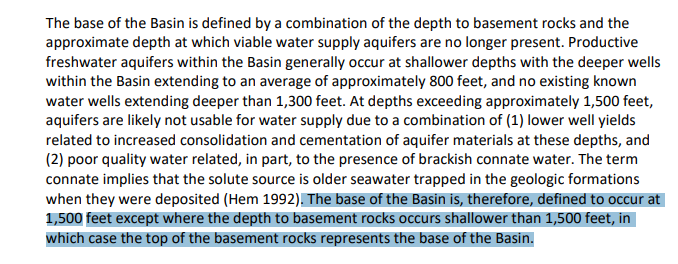

# Santa Rosa Plain
### Shallow
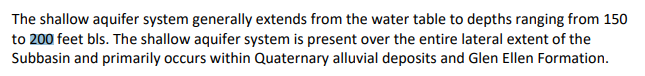

### Deep
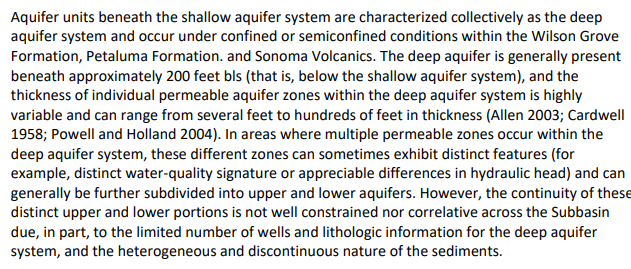

# Sonoma Valley
### Shallow
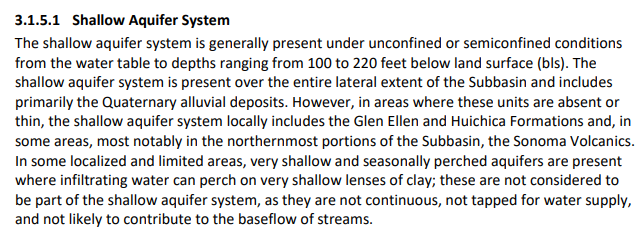

### Deep
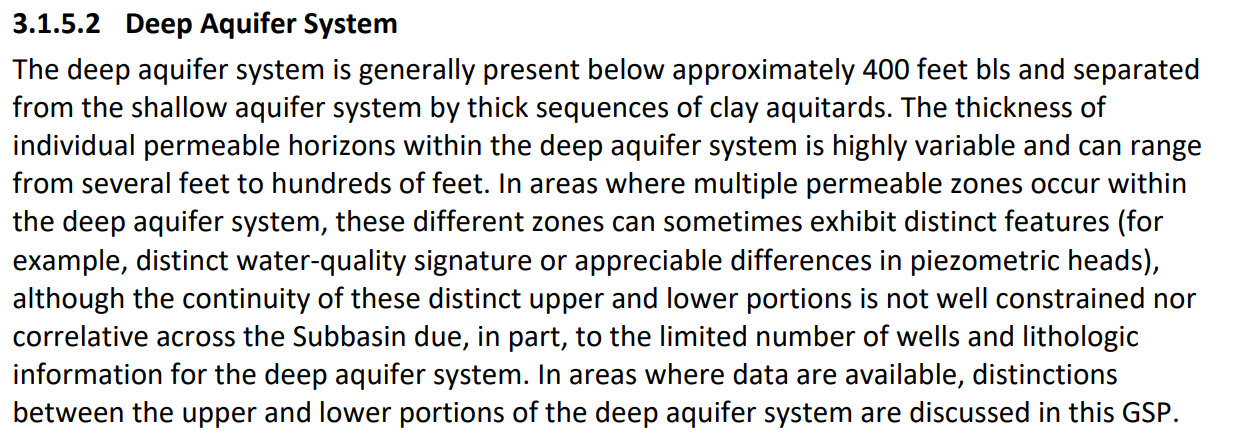

In [ ]:
if basin=='PET':
    for lay in range(mod.ml.dis.nlay):
        ma = (mod.ml.bas6.ibound.array[lay]==0)  |  (mod.ml.dis.botm.array[lay]*mod.unit < -1500)
        fig, ax = plot_help.plot_model_array(mod.ml,np.ma.MaskedArray( mod.ml.dis.botm.array[lay]*mod.unit, ma), title = '')
        ax.set_title(f"layer {lay+1}")


for lay in range(mod.ml.dis.nlay):
    ma = (mod.ml.bas6.ibound.array[lay]==0)
    ar = np.ma.MaskedArray( mod.ml.modelgrid.thick[lay]*mod.unit, ma)
    print(f"layer thickness {lay+1}, {ar.mean():.0f}")
    fig, ax = plot_help.plot_model_array(mod.ml,ar, title = '')
    ax.set_title(f"layer {lay+1} thickness")
    ax.text(0,1, f"layer {lay+1} average thickness:\n{ar.mean():.0f} ft", va = 'top',transform = ax.transAxes)
    
    plt.savefig(os.path.join(mod.out_folder,f'layer{lay+1}_thickness.png'))
    

In [ ]:

df = get_df_combined(dfall, deep_mod, shallow_mod, deep = True)

ax = df.cumsum().plot(marker = '.')

ax.legend(bbox_to_anchor = (1,1))
ax.set_title('Cumulative Storage Change - Deep')
ax.grid(True)

plt.savefig(os.path.join(mod.out_folder, f"storage change comp with modeled deep.png"), bbox_inches = 'tight')

In [ ]:

df = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)

ax = df.cumsum().plot(marker = '.')

ax.legend(bbox_to_anchor = (1,1))
ax.set_title('Cumulative Storage Change - Shallow')
ax.grid(True)

plt.savefig(os.path.join(mod.out_folder, f"storage change comp with modeled shallow.png"), bbox_inches = 'tight')


In [ ]:


df = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)
df = df.dropna(axis=0)

fig, axes = plt.subplots(2, sharex = True)
ax = axes[0]
df.plot(ax = ax, marker = '.')
ax.grid(True); 
ax.legend(bbox_to_anchor = (1,1))
ax.set_title('Yearly Storage Change')

# axy = ax.twinx()

df_diff = df.assign(diff=df.diff(axis=1).dropna(axis=1))
df_diff.loc[:,'diff'].plot(ax=axes[1], c = 'g')
axes[1].grid(True)
axes[1].set_title('Difference Between Estimates')

plt.savefig(os.path.join(mod.out_folder, f"yearly  storage change comp with modeled shallow.png"), bbox_inches = 'tight')


In [ ]:
# 1x1 plot

fig, ax = plt.subplots(1, sharex = True)
# ax = axes[0]
df = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)
df = df.dropna(axis=0)

df.plot(x = df.columns[0], y = df.columns[1], ax = ax, marker = '.', linestyle = "None", label = None)
ax.grid(True); 
# ax.legend(bbox_to_anchor = (1,1))
ax.set_title('Yearly Storage Change, Shallow')
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.axis('equal')
ax.legend().remove()
ax.plot([df.min().min(),  df.max().max(),], [df.min().min(), df.max().max(), ])

plt.savefig(os.path.join(mod.out_folder, f"yearly 1x1 storage change comp with modeled shallow.png"), bbox_inches = 'tight')

# 1x1 plot

fig, ax = plt.subplots(1, sharex = True)
# ax = axes[0]
df = get_df_combined(dfall, deep_mod, shallow_mod, deep = True)
df = df.dropna(axis=0)

df.plot(x = df.columns[0], y = df.columns[1], ax = ax, marker = '.', linestyle = "None", label = None)
ax.grid(True); 
# ax.legend(bbox_to_anchor = (1,1))
ax.set_title('Yearly Storage Change, Deep')
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.axis('equal')
ax.legend().remove()
ax.plot([df.min().min(),  df.max().max(),], [df.min().min(), df.max().max(), ])

plt.savefig(os.path.join(mod.out_folder, f"yearly 1x1 storage change comp with modeled deep.png"), bbox_inches = 'tight')

In [ ]:

# dfjoin = dfall.filter(like = 'Fall').droplevel(1,1).join(hist).loc['1975':,]
# dfjoin = dfjoin.cumsum().dropna(axis=0)
# # dfjoin = dfjoin.iloc[:,[1,2]]
# dfjoin = dfjoin.filter(regex = 'lay1|lay2|Sha')
# dfjoin = dfjoin.assign(NumericalModel=dfjoin.filter(regex = 'lay').sum(axis=1)).drop(columns =dfjoin.filter(regex = 'lay').columns )

# ax = dfjoin.plot(marker = '.')

# ax.legend(bbox_to_anchor = (1,1))
# ax.set_title('Cumulative Storage Change - Shallow')
# ax.grid(True)
# plt.savefig(os.path.join(mod.out_folder, f"storage change comp with modeled shallow.png"), bbox_inches = 'tight')

# ####
# dfjoin = dfall.filter(like = 'Fall').droplevel(1,1).join(hist).dropna(axis=0)
# dfjoin = dfjoin.iloc[:,[1,2]].loc['1980':,]

# # for c in dfjoin.columns:
# #     dfjoin.loc[:,c] = dfjoin.loc[:,c]-dfjoin.loc[:,c].values[0]

# fig, axes = plt.subplots(2, sharex = True)
# ax = axes[0]
# dfjoin.plot(ax = ax, marker = '.')
# ax.grid(True); 
# ax.legend(bbox_to_anchor = (1,1))
# ax.set_title('Yearly Storage Change')

# # axy = ax.twinx()

# df_diff = dfjoin.assign(diff=dfjoin.diff(axis=1).dropna(axis=1))
# df_diff.loc[:,'diff'].plot(ax=axes[1], c = 'g')
# axes[1].grid(True)

# plt.savefig(os.path.join(mod.out_folder, f"yearly  storage change comp with modeled shallow.png"), bbox_inches = 'tight')


# # 1x1 plot

# fig, ax = plt.subplots(1, sharex = True)
# # ax = axes[0]
# dfjoin.plot(x = 'lay1', y = 'Shallow, Fall', ax = ax, marker = '.', linestyle = "None", label = None)
# ax.grid(True); 
# # ax.legend(bbox_to_anchor = (1,1))
# ax.set_title('Yearly Storage Change')
# ax.set_xlabel('SRPHM, AF')
# ax.set_ylabel('ML Estimate, AF')
# ax.axis('equal')
# ax.plot([dfjoin.min().min(),  dfjoin.max().max(),], [dfjoin.min().min(), dfjoin.max().max(), ])

# plt.savefig(os.path.join(mod.out_folder, f"yearly 1x1 storage change comp with modeled shallow.png"), bbox_inches = 'tight')





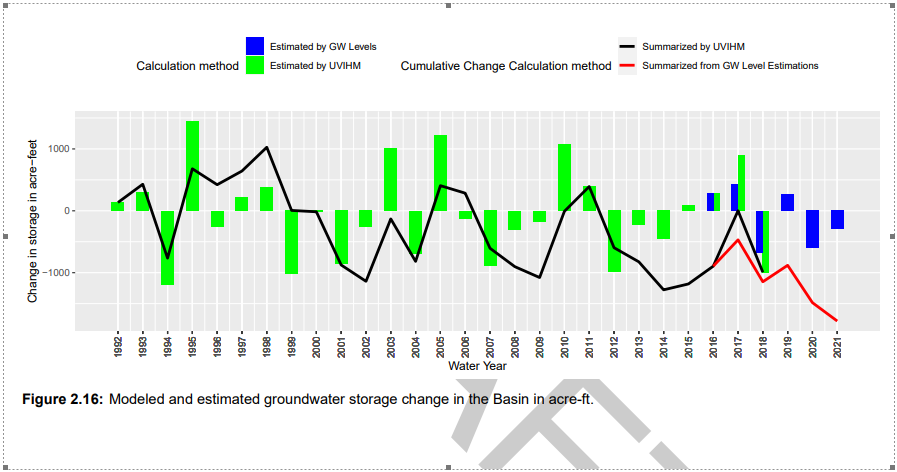

In [ ]:
def get_offset(df, year):
    d = df.loc[[f'{year}'],:]
    d = d.diff(axis=1).values[0][1]
    return d
    
df = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)
df = df.cumsum()
df = df.set_index(pd.to_datetime(df.index, format = "%Y"))
d = get_offset(df,2011)

d

In [ ]:
dfall

In [ ]:
# df = get_df_combined(dfall, deep_mod, shallow_mod, deep = False)
# dfc = df.dropna().cumsum()
# # dfc.loc[:,'d'] = dfc.diff(axis=1).dropna(axis=1)
# dfc.loc[:,'n'] = dfc.loc[:,'n']
# dfc.plot()
# print(dfc)

In [ ]:
def get_wl_cum(deep, num_ml):
    '''
    deep: True/False
    num_ml: column number, 0: GWLE, 1: GW model 
    '''
    df = get_df_combined(dfall, deep_mod, shallow_mod, deep = deep)
    df = df.set_index(pd.to_datetime(df.index, format = "%Y"))
    df = df.dropna(axis=0)
    
    if num_ml:
        col = 1
    else:
        col = 0
    
    if (num_ml == 1):
        assert "Numerical" in df.columns[col], f"column name: {df.columns[col]}"
    
    dfsum = df.cumsum().loc[:,df.columns[col]]
    dfsum.loc[dfsum.index.min()-pd.to_timedelta(365, unit = 'D')] = 0
    dfsum = dfsum.sort_index()
    
    return dfsum

get_wl_cum(False, 1).head()

In [ ]:
mod.folder

In [ ]:
def get_offset_df(year, deep, num_ml):
    df = get_df_combined(dfall, deep_mod, shallow_mod, deep = deep)
    df = df.dropna()
    df = df.set_index(pd.to_datetime(df.index, format = "%Y"))
    df = df.cumsum()
    
    
    d = df.loc[[f'{year}'],:]
    print(d)
    d = d.diff(axis=1).values[0][1]
    
    print(d)
    
    if num_ml:
        col = 1
    else:
        col = 0
    
    if (num_ml == 1):
        assert "Numerical" in df.columns[col], f"column name: {df.columns[col]}"
    
    
    
    _df = get_df_combined(dfall, deep_mod, shallow_mod, deep = deep)
    _df = _df.set_index(pd.to_datetime(_df.index, format = "%Y"))
    #get first year of ml model and start GWLE series from there
    c_ =df.index.min()
    _df = _df.loc[c_:,:].cumsum()
    df_no_offset = _df.copy()
    df_no_offset.loc[df_no_offset.index.min()-pd.to_timedelta(365, unit = 'D')] = 0
    df_no_offset = df_no_offset.sort_index()
    _df.loc[:,'offset'] = _df.loc[:,df.columns[col]]+d
    _df.loc[:,'og'] = _df.loc[:,df.columns[col]]
    df = df.reindex(_df.index)
    df.loc[_df.index,'offset'] = _df.loc[:,'offset']

    
    
    
    return df, df_no_offset

df, dfnooffset = get_offset_df(2011, False, 0)
df.loc['2010':].head(3)

In [ ]:
df, dfnooffset = get_offset_df(2011, False, 0)
dfnooffset.head(2)

In [ ]:

c1 = 'b'
c2 = 'orange'
lw = 2
ec = 'grey'
marker = 'o'
ms = 3
width = 365
pe =  [path_effects.Stroke(linewidth=lw+5, foreground='k', alpha = .8 ),
       path_effects.Normal()]

_show_unfilt_no_offset = False

for _show_unfilt_no_offset in [True, False]:
    for deep in [True, False]:

        if deep:
            label = 'deep'
        else:
            label = 'shallow'
        fig = plt.figure(figsize= (10,8))
        ax = plt.subplot()

        df = get_df_combined(dfall, deep_mod, shallow_mod, deep = deep)
        df = df.set_index(pd.to_datetime(df.index, format = "%Y"))


        offset = pd.to_timedelta(width/2, unit = 'D')
        rects1 = ax.bar(df.index + 0*offset, df.iloc[:,1], width/2, color  = c1, edgecolor=ec,align = 'edge',
                         label='Annual Storage Change,\nGroundwater Flow Model Estimated')

        if _show_unfilt_no_offset:
            df_cur = df.copy()
        else:
            df_cur = df.loc['2012':,:]

        rects2 = ax.bar(df_cur.index + offset, df_cur.iloc[:,0],width/2, color  = c2, edgecolor=ec,align = 'edge',
                         label='Annual Storage Change,\nGWLE Estimated')

        xl = ax.get_xlim()

        df_cum_ml = get_wl_cum(deep, 1)


        ax.plot(df_cum_ml.index+pd.to_timedelta(365/2, unit = 'D'), df_cum_ml.values, color = 'b', 
                path_effects =pe, lw = lw, marker = marker, ms = ms,
                label = 'Cumulative Storage Change,\nGroundwater Flow Model Estimated')

        dfsum, df_no_offset = get_offset_df(2011, deep, 0)
        dfsum = dfsum.loc['2011':,:]


        ax.plot(dfsum.index+pd.to_timedelta(365/2, unit = 'D'), dfsum.loc[:,'offset'].values, c = 'orange', 
                path_effects =pe, lw = lw,  marker = marker, ms = ms,
                label = 'Cumulative Storage Change,\nGWLE Estimated')

        if _show_unfilt_no_offset:
            ax.plot(df_no_offset.index+pd.to_timedelta(365/2, unit = 'D'), df_no_offset.iloc[:,0].values, c = 'r', 
                    path_effects =pe, lw = lw,  marker = marker, ms = ms,
                    label = 'Cumulative Storage Change,\nNo offset')


        leg = ax.legend(bbox_to_anchor = (1,1), loc = 'upper left')
        
        

        
        # style the plot
        conda_scripts.plot_wet.plot_hist(fig = fig, ax = ax, calwy_plot = True)
        ax.set_xlim(xl)
        ax.set_xlabel('Water Year')
        plot_help.baseline(ax, yearend=year+1)
        
        new_hands, ind_forleg, hand_wetdry, lab_wetdry = conda_scripts.plot_help.remove_wet_dry_legend(ax,
        legend_order=None, remove_wet_dry=False, leg_title='', ncol=1)

        ax.set_title(f'Groundwater Storage Change, {label} Aquifer'.title())
        ax.set_ylabel('acre-feet')

        thick =  mod.thickness_deep if deep else mod.thickness_shallow
        layers = [x+1 for x in mod.ml_deep_layer] if deep else [x+1 for x in mod.ml_shallow_layer]
        boxtemx = \
        "GWLE Info:\nAquifer Thickness: {:} ft\n".format(thick)+\
        "Model Layers: {:}".format(layers)
                
        
        ax.text(1.02,0.6,boxtemx,  transform= ax.transAxes,  style='italic')
        
        if _show_unfilt_no_offset:
            ax.text(1,1,'Internal Use Only',  transform= ax.transAxes, fontsize = 16,
                    color = 'r',
                    weight='bold',  style='italic')

        plt.savefig(os.path.join(mod.out_folder, f"yearly storage change comp with modeled {label}, {_show_unfilt_no_offset}.png"), bbox_inches = 'tight',dpi = 300)
        plt.savefig(os.path.join(mod.share_folder, f"yearly storage change comp with modeled {label} {_show_unfilt_no_offset}.png"), bbox_inches = 'tight',dpi = 300)

In [ ]:
def read_resid(folder):
    r = "seasinfo_w_predicted_SRP.csv"
    
    if os.path.exists(os.path.join(folder,r) ):
        tab = pd.read_csv(os.path.join(folder,r))
    else:
        tab = None
    return tab

tab = read_resid(mod.folder.replace('maps','hydros'))

if not tab is None:
    tab.loc[:,'residual'] = tab.loc[:,'Manual Measurement'] - tab.loc[:,'predicted']
    
    tab.residual.hist(bins = np.arange(-1,1,.2))

In [ ]:
import plotly.graph_objects as go


In [ ]:
# x = wl.to_dataframe()

# x = x.reset_index()
# x = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.easting,x.northing, crs= 2226),crs= 2226)
# x = gpd.clip(x,bas.query("Basin_Name.str.contains('SAN')"))
# x = x.to_crs(4326)
# x = x.query("year==2018").dropna(axis=0, how = 'any')
# x.loc[:,'lat'] = x.geometry.y
# x.loc[:,'lon'] = x.geometry.x
# # x = x.head(100)
# fig = px.scatter_mapbox(x, lat = 'lat', lon = 'lon' , color="Head")
# fig.update_geos(fitbounds="locations", visible=False)

# fig.update_layout(mapbox_style='stamen-terrain')
# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.update_layout(title_text="Air quality level in Europe 2018")
# # fig.show()

# fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
# import dash_core_components as dcc
import dash.dcc as dcc
# import dash_html_components as html
import dash.html as html
# from dash.dependencies import Input, Output

In [ ]:
basin = mod.basin

In [ ]:
basin

In [ ]:
folder = mod.folder
print(folder)

In [ ]:
# fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

def get_wl_map_xr(folder, change = False, ):
    bas = conda_scripts.rich_gis.get_active_subbasins()
    
    if change:
        wl = os.path.join(folder,"wl_change_predictions_Shallow_Fall.netcdf")
    else:
        wl = os.path.join(folder,"wl_predictions_Shallow_Fall.netcdf")
    wl = xr.open_dataset(wl)

    
    return wl


def get_wl_map(change = False):
    bas = conda_scripts.rich_gis.get_active_subbasins()
    
    if change:
        wl = os.path.join(folder,"wl_change_predictions_Shallow_Fall.netcdf")
    else:
        wl = os.path.join(folder,"wl_predictions_Shallow_Fall.netcdf")
    wl = xr.open_dataset(wl)
    x = wl.to_dataframe()

    x = x.reset_index()
    b = basin.upper()
    x = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.easting,x.northing, crs= 2226),crs= 2226)
    x = gpd.clip(x,bas.query("Basin_Name.str.contains(@b)"))
    x = x.to_crs(4326)
    # x = x.query("year==2018").dropna(axis=0, how = 'any')
    x.loc[:,'lat'] = x.geometry.y
    x.loc[:,'lon'] = x.geometry.x
    x = x.sort_values('year')
    
    return x

def get_wl_ch_custom(yearstart = 1976, yearend = 2018, wl=None):
    if wl is None:
        wl = get_wl_map_xr(folder, False)
    wlch = wl.sel(year = yearend).to_array('Head')-wl.sel(year = yearstart).to_array('Head')
    # x = wlch.to_dataframe()
    x = wlch.to_dataframe('Water Level Change').droplevel(0)

    x = x.reset_index()
    x = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.easting,x.northing, crs= 2226),crs= 2226)
    bas = conda_scripts.rich_gis.get_active_subbasins()
    b = basin.upper()
    x = gpd.clip(x,bas.query("Basin_Name.str.contains(@b)"))
    x = x.to_crs(4326)
    # x = x.query("year==2018").dropna(axis=0, how = 'any')
    x.loc[:,'lat'] = x.geometry.y
    x.loc[:,'lon'] = x.geometry.x
    # x = x.sort_values('year')
    
    return x

def get_3_maps(yearstart, yearend, wl):
    diff = get_wl_ch_custom(yearstart,yearend)   
    wlstart = wl.query(f"year=={yearstart}")
    wlend = wl.query(f"year=={yearend}")
    
    return diff, wlstart, wlend

wl = get_wl_map(change = False)
diffmap, wlstart, wlend = get_3_maps(2000, 2023, wl)

In [ ]:
x = get_wl_ch_custom(2022,2023)
x.drop(columns = 'geometry').sum().at['Water Level Change']*600*600*.15/43560

In [ ]:

# x = get_wl_ch_custom()
# fig1 = px.scatter_mapbox(x, lat = 'lat', lon = 'lon' , range_color = [-20,20],
#                         color="Water Level Change",width = 700, height= 700,
#                         mapbox_style = 'open-street-map',
#                          color_continuous_scale=px.colors.diverging.Portland_r,
#                          hover_name= 'Water Level Change',
#                          zoom =10)
# fig1.update_geos(fitbounds="locations", visible=False)
# fig1["layout"].pop("updatemenus") # optional, drop animation buttons

# x = get_wl_map(change = True)
# fig2 = px.scatter_mapbox(x, lat = 'lat', lon = 'lon' , range_color = [-20,20],
#                         color="Head",
#                          animation_frame="year",
#                          width = 700, height= 700,
#                          hover_name= 'Head',
#                         mapbox_style = 'open-street-map',
#                          color_continuous_scale=px.colors.cyclical.IceFire, zoom =10)
# fig2.update_geos(fitbounds="locations", visible=False)


# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# app = JupyterDash(external_stylesheets=external_stylesheets)


# app.layout = html.Div([
#     html.Div([
#         html.Div([
#             html.H3('Simulated Head Difference'),
#             dcc.Graph(id='g1', figure=fig1)
#         ], className="six columns"),

#         html.Div([
#             html.H3('IGNOFRE'),
#             dcc.Graph(id='g2', figure=fig2)
#         ], className="six columns"),
#     ], className="row")
# ])

# # Run app and display result inline in the notebook
# app.run_server(mode = 'external',port=8053)



In [ ]:
import dash
wl= get_wl_map(change = False)

wl_xr = get_wl_map_xr(mod.folder,False)

In [ ]:
wl_xr

In [ ]:
mod.folder

In [ ]:


def get_points(folder, year):
    f = f'{mod.basin.upper()}_{year}_Fall_Shallow.shp'
    
    if os.path.exists(os.path.join(folder, 'allpoints.csv')):
        pts = pd.read_csv(os.path.join(folder, 'allpoints.csv'))     
        pts = pts.loc[pts.loc[:,'filename'].isin([f])]
        pts = pts.drop(columns = ['geometry','Easting','Northing'])

        return pts
    

    if not os.path.exists(os.path.join(folder, f)):
        p = os.path.join(folder, f)
        return None
    pts = gpd.read_file(os.path.join(folder, f))
    pts = pts.to_crs(4236)
    pts.loc[:,'Latitude'] = pts.geometry.y
    pts.loc[:,'Longitude'] = pts.geometry.x
    pts = pts.drop(columns = ['geometry','Easting','Northing'])
    
    return pts

def add_points(gdf, fig):
    if gdf is None:
        return fig
    
    hovertext =['Station Na','label']
    fig.add_scattermapbox(
        lon = gdf['Longitude'],
        lat = gdf['Latitude'],
        hoverinfo = 'text',
        # hovertext = ['Station Na','label'],
        text = gdf.loc[:,'Station Na']+'<br>'+gdf.loc[:,'label'],
        mode = 'markers+text',
        name = '',
        marker = dict(
            size = 10,
            color = gdf.loc[:,'Residual'],
            cmin=-20,
            cmax=20,))
    return fig

In [ ]:
def collect_points(folder,season = 'Fall', depth = 'Shallow'):
    
    f = os.listdir(folder)
    
    f = [x for x in f if x.endswith(f'_{season}_{depth}.shp')]
    
    return f

def collate_points(files,folder):
    
    meas_pts = pd.DataFrame()
    for file in files:
        _df = gpd.read_file(os.path.join(folder, file))
        
        _df.loc[:,'filename'] = file
        
        meas_pts = meas_pts.append(_df)
        

    meas_pts.loc[:,'Latitude'] = meas_pts.to_crs(4326).geometry.y
    meas_pts.loc[:,'Longitude'] = meas_pts.to_crs(4326).geometry.x
    
    meas_pts.to_csv(os.path.join(folder, 'allpoints.csv'))
    return meas_pts

files = collect_points(folder,season = 'Fall', depth = 'Shallow')

allpoints = collate_points(files,folder)

In [ ]:
def collect_lines(folder,season = 'Fall', depth = 'Shallow'):
    
    fall = []
    for cntr in [20, 100]:
        f = os.listdir(folder)

        f = [x for x in f if x.endswith(f'_{season}_{depth}_cnt{cntr}ft.shp')]
        fall.extend(f)
    
    return fall

def collate_lines(files,folder):
    
    meas_pts = pd.DataFrame()
    for file in files:
        _df = gpd.read_file(os.path.join(folder, file))
        
        _df.loc[:,'filename'] = file
        
        meas_pts = meas_pts.append(_df)
        
    meas_pts.loc[:,'year'] = meas_pts.filename.str.split('_').str[1].astype(int)
    meas_pts.loc[:,'depth'] = meas_pts.filename.str.split('_').str[3]
    meas_pts.loc[:,'contour'] = meas_pts.filename.str.split('_').str[4].str.replace('ft.shp','').str.replace('cnt','').astype(int)
    
    # meas_pts = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.easting,x.northing, crs= 2226),crs= 2226)
    
    bas = conda_scripts.rich_gis.get_active_subbasins()
    # bas = bas.to_crs(4326)
    meas_pts = gpd.clip(meas_pts,bas.query("Basin_Name.str.contains(@basin)"))
    
#     meas_pts  = meas_pts.explode(ignore_index=True)
    
#     c = meas_pts.geometry.length > 1000
    
#     meas_pts = meas_pts.loc[c]
    
    
    # meas_pts.loc[:,'Latitude'] = meas_pts.to_crs(4326).geometry.y
    # meas_pts.loc[:,'Longitude'] = meas_pts.to_crs(4326).geometry.x
    
    # meas_pts.to_csv(os.path.join(folder, 'allpoints.csv'))
    return meas_pts

lines_files = collect_lines(folder,season = 'Fall', depth = 'Shallow')

alllines = collate_lines(lines_files,folder)

In [ ]:
def add_cntours(gdf, fig):
    if gdf is None:
        return fig
        
        ## Loop thorugh each flight entry
    for _,n in gdf.query('contour==100').iterrows():
        fig.add_trace(go.Scattermapbox(
                            lat = np.array(n['geometry'].coords)[:,1],
                            lon = np.array(n['geometry'].coords)[:,0],
                            mode = 'lines',
                            text = n['elev'],
                            line = dict(width = 3, color="black"),
                            showlegend=False
                            ))
        
    for _,n in gdf.query('contour==20').iterrows():
        fig.add_trace(go.Scattermapbox(
                            lat = np.array(n['geometry'].coords)[:,1],
                            lon = np.array(n['geometry'].coords)[:,0],
                            mode = 'lines',
                            text = n['elev'],
                            line = dict(width = 1.5, color="black"),
                            showlegend=False
                            ))
    return fig


def get_lines(alllines, year):
    pts = alllines.query(f"year=={year}")
    
    pts = pts.explode()
    pts = pts[pts.geometry.length>1000]
    pts = pts.to_crs(4236)

    
    return pts

In [ ]:
fig = px.scatter_mapbox(allpoints,
                       lat = "Latitude",
                       lon = "Longitude",
                       mapbox_style = 'open-street-map',height = 1000)

pts = get_lines(alllines, 2000)
fig = add_cntours(pts, fig)


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(external_stylesheets=external_stylesheets)


app.layout = html.Div([
 dcc.Graph(figure=fig)
])

# Run app and display result inline in the notebook
app.run_server(mode = 'external',port=8053)

In [ ]:
sdfasdf

In [ ]:
basin

In [ ]:
wl.query(f"year=={year}")

In [ ]:
# year = 2000
# hover = {xi:False for xi in wl.drop(columns = 'geometry').columns}
# hover['Head'] =':.1f'

# # geo = wl.query(f"year=={year}").to_crs(2226).buffer(500).to_crs(4326).geometry
# geo = wl.query(f"year=={year}").to_crs(2226).buffer(500,
#                             cap_style = 'square').to_crs(4326).geometry

# fig1 = px.choropleth_mapbox(wl.query(f"year=={year}"),
#                             geojson = geo,
#                             locations=wl.query(f"year=={year}").index,
#                          range_color = [0,150],
#                         color="Head",
#                         width = 700, height= 700,
#                         mapbox_style = 'open-street-map',
#                          color_continuous_scale=px.colors.diverging.RdYlBu,
#                          custom_data = ['Head'],
#                          hover_data= hover,
#                          title=f"WaterLevel for Year {year}",
#                          zoom =10)
    
# fig1.update_geos(fitbounds="locations", visible=False)
# fig1["layout"].pop("updatemenus") # optional, drop animation buttons
# fig1.show()

In [ ]:
# gw_data.drop_duplicates(gw_data.loc[:,'ts_name':].columns).sort_values('ts_name')

In [ ]:

map_center = {'SON':{"lat": 38.245, "lon": -122.439},
             'PET':{"lat": 38.229, "lon": -122.59}}

def get_f1(year):
    hover = {xi:False for xi in wl.drop(columns = 'geometry').columns}
    hover['Head'] =':.1f'
    
    geo = wl.query(f"year=={year}").to_crs(2226).buffer(500,
                            cap_style = 'square').to_crs(4326).geometry

    fig1 = px.choropleth_mapbox(wl.query(f"year=={year}"),
                    geojson = geo,
                    locations=wl.query(f"year=={year}").index,
                    range_color = [0,150],
                    color="Head",
                    width = 700, height= 700,
                    mapbox_style = 'open-street-map',
                    color_continuous_scale=px.colors.diverging.RdYlBu,
                    custom_data = ['Head'],
                    hover_data= hover,
                    title=f"WaterLevel for Year {year}",
                    center=map_center[basin.upper()],
                    zoom =10, 
                    opacity = .5)

    
    fig1.update_geos(fitbounds="locations", visible=False)
    fig1["layout"].pop("updatemenus") # optional, drop animation buttons
    lines = get_lines(alllines, year)
    fig1 = add_cntours(lines, fig1)
    
    gdf = get_points(folder, year)
    fig1 = add_points(gdf, fig1)
    



    return fig1


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(external_stylesheets=external_stylesheets)



@app.callback(
    dash.dependencies.Output('g1', 'figure'),
    [dash.dependencies.Input('year-slider', 'value')])
def f1(year):
    return get_f1(year[0])

@app.callback(
    dash.dependencies.Output('g2', 'figure'),
    [dash.dependencies.Input('year-slider', 'value')])
def f2(year):
    return get_f1(year[1])
    
@app.callback(
    dash.dependencies.Output('g3', 'figure'),
    [dash.dependencies.Input('year-slider', 'value')])
def diff_figure(year):
    wlch = get_wl_ch_custom(yearstart = year[0], yearend = year[1], wl=wl_xr)
    
    hover = {xi:False for xi in wlch.drop(columns = 'geometry').columns}
    hover['Water Level Change'] =':.1f'
    
    fig_diff = px.scatter_mapbox(wlch.drop(columns = 'geometry'), lat = 'lat', lon = 'lon' , range_color = [-10,10],
                              # custom_data = ['Water Level Change'],
                             hover_data= hover,
                            color='Water Level Change',
                             width = 700, height= 700,
                             # hover_name= 'Water Level Change',
                            mapbox_style = 'open-street-map',
                             title=f"WaterLevel Changes Between Year {year[0]} and {year[1]}",
                             color_continuous_scale=px.colors.cyclical.IceFire_r,
                        center=map_center[basin.upper()], zoom =10)
    fig_diff.update_geos(fitbounds="locations", visible=False)
    
    return fig_diff
  
    
app.layout = html.Div([

        dcc.Graph(id='g1'),
        dcc.Graph(id='g2'),
        dcc.Graph(id='g3'),

    dcc.RangeSlider(
        id='year-slider',
        min=1975,
        max=2022,
        value = [2021, 2022],
        marks={str(year): str(year) for year in wl['year'].unique()},
        # marks = {str(year):str(year) for year in np.arange(1975,2021,5)},
        step=5)
])


# Run app and display result inline in the notebook
app.run_server(mode = 'external',port=8052)

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df['airport'] + '' + df['city'] + ', ' + df['state'] + '' + 'Arrivals: ' + df['cnt'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['long'],
        lat = df['lat'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df['cnt'],
            cmax = df['cnt'].max(),
            colorbar_title="Incoming flights<br>February 2011"
        )))

fig.update_layout(
        title = 'Most trafficked US airports<br>(Hover for airport names)',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [ ]:
diffmap.loc[:,'Water Level Change'].nunique()

In [ ]:
wl = get_wl_map(change = False)
diffmap, wlstart, wlend = get_3_maps(2000, 2015, wl)

marker1 = dict(
    size = 8,
    opacity = 0.8,
    reversescale = True,
    autocolorscale = False,
    symbol = 'square',
    colorscale = 'icefire',
    color = diffmap.loc[:,"Water Level Change"],
    cmax = 20,
    cmin = -20,
    colorbar_title="Waterlevel Change<br>February 2011",
    colorbar=dict(len=0.25,y = 1)
)

import copy
marker2 = copy.deepcopy(marker1)
marker2['colorbar']['y']=.5
marker2['cmax']=200
marker2['cmin']=20
marker2['color']=wlstart.loc[:,"Head"]

marker3 = copy.deepcopy(marker1)
marker3['colorbar']['y']=0
marker3['cmax']=200
marker3['cmin']=20
marker3['color']=wlend.loc[:,"Head"]

# colorbar = dict( title='Nb moyen', thickness=15)
# colorscale = 'Blues',
# color = df.loc[:,"Water Level Change"],
# cmax = df.loc[:,"Water Level Change"].max(),
# cmin = df.loc[:,"Water Level Change"].min(),
# colorbar_title="Incoming flights<br>February 2011"


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Initialize figure with subplots
fig = make_subplots(
    rows=3, cols=1,
    specs=[[{"type": "scattergeo"}] ,
           [ {"type": "scattergeo"}],
           [ {"type": "scattergeo"}]],
row_titles=['Water Level Change', "Waterlevel Start", "Waterlevel End"]
)

# Add scattergeo globe map of volcano locations
fig.add_trace(
    go.Scattergeo(lat=diffmap["lat"],
                  lon=diffmap["lon"],
                  mode="markers",
                  hoverinfo="text",
                  text=np.round(diffmap['Water Level Change'],1),
                  showlegend=False,
                  marker = marker1),
     col=1,row = 1
)

# Add scattergeo globe map of volcano locations
fig.add_trace(
    go.Scattergeo(lat=wlstart["lat"],
                  lon=wlstart["lon"],
                  mode="markers",
                  hoverinfo="text",
                  text=np.round(wlstart['Head'],1),
                  showlegend=False,
                  marker = marker2),
     col=1,row = 2
)

# Add scattergeo globe map of volcano locations
fig.add_trace(
    go.Scattergeo(lat=wlend["lat"],
                  lon=wlend["lon"],
                  mode="markers",
                  hoverinfo="text",
                  text=np.round(wlend['Head'],1),
                  showlegend=False,
                  marker = marker3,
                 ),
     col=1,row = 3,)

# fig.update_mapboxes(style='carto-positron', zoom=8, center = dict(lat = 39., lon=-119.))

fig.update_geos(
    projection_type="transverse mercator",
    landcolor="white",
    oceancolor="MidnightBlue",
    showocean=True,
    lakecolor="LightBlue",
    center = dict(lat = 39., lon=-119.),
    fitbounds="locations", visible=False
)



# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=25, b=40, l=60),
    height= 1500,
    annotations=[
        dict(
            text="Source: NOAA",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0)
    ]
    ,

)



# fig.update_layout(
#     height = 2000,
#     style='open-street-map',
# )


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Graph(figure=fig)
])


# Run app and display result inline in the notebook
app.run_server(mode = 'external',port=8053)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# read in volcano database data
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/volcano_db.csv",
    encoding="iso-8859-1",
)

# frequency of Country
freq = df
freq = freq.Country.value_counts().reset_index().rename(columns={"index": "x"})

# read in 3d volcano surface data
df_v = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/volcano.csv")

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[[{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "surface"}]])

# Add scattergeo globe map of volcano locations
fig.add_trace(
    go.Scattergeo(lat=df["Latitude"],
                  lon=df["Longitude"],
                  mode="markers",
                  hoverinfo="text",
                  showlegend=False,
                  marker=dict(color="crimson", size=4, opacity=0.8)),
    row=1, col=1
)

# Add locations bar chart
fig.add_trace(
    go.Bar(x=freq["x"][0:10],y=freq["Country"][0:10], marker=dict(color="crimson"), showlegend=False),
    row=1, col=2
)

# Add 3d surface of volcano
fig.add_trace(
    go.Surface(z=df_v.values.tolist(), showscale=False),
    row=2, col=2
)

# Update geo subplot properties
fig.update_geos(
    projection_type="orthographic",
    landcolor="white",
    oceancolor="MidnightBlue",
    showocean=True,
    lakecolor="LightBlue",
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=25, b=40, l=60),
    annotations=[
        dict(
            text="Source: NOAA",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0)
    ]
)

fig.show()

In [ ]:
def get_mask(basin, filename=r'C:\GSP\waterlevel\regression_data\allbasin_mask.nc'):
    '''
    get mask for models
    :param filename:
    :return:
    '''

    bas_dict = {'SRP': 1, 'SON': 2, 'PET': 0}
    if not (basin.upper() in bas_dict.keys()):
        raise ValueError(f"basin not in basin_dict"
                         'use {bas_dict.keys()}')
    else:
        print(f"getting mask for {basin}")
    
    
    basin_value = bas_dict[basin.upper()]
    m = xr.open_dataarray(filename)
    m = m.where(m==basin_value).notnull()
    m = m.rename({'lon': 'easting',
                        'lat': 'northing'})
    return m


#     return mask

mask = get_mask("PET")

mask.plot()

In [ ]:
mask.to_dataframe('m').value_counts()

In [ ]:
mask = m.where(m==1)>0

In [ ]:
m.where(mask).plot()

In [ ]:
filename=r'C:\GSP\waterlevel\regression_data\allbasin_mask.nc'
m = xr.open_dataarray(filename)

m.where(m==1,1).plot()

In [ ]:
mask.where(mask.notnull()) == 1

In [ ]:
mask.to_dataframe('h').h.unique()

In [ ]:
wl = os.path.join(mod.folder,"wl_change_predictions_Deep_Spring.netcdf")

# wl = wl.replace('Deep',x).replace('Fall',fall)

wl = xr.open_dataset(wl)

wl.Head.sel(year =2000)

p = wl.Head.where(np.logical_or(wl.Head>1, wl.Head<-1)).plot(
     col='year', col_wrap=4, vmin = -100, vmax = 100 ,
    cmap=mpl.cm.coolwarm_r, center = 0,
    subplot_kws={'projection': ccrs.epsg(2226)})  

In [ ]:
mod.out_folder

In [ ]:
mask = pp.get_mask()

In [ ]:
os.path.join(folder,f"{x} Aquifer {fall}.png")

In [ ]:
bas = conda_scripts.rich_gis.get_active_subbasins()
for fall in ['Fall','Spring']:
    for x in ['Deep','Shallow']:
        wl = os.path.join(mod.folder,"wl_change_predictions_Deep_Spring.netcdf")

        wl = wl.replace('Deep',x).replace('Fall',fall)

        wl = xr.open_dataset(wl)

        # This is the map projection we want to plot *onto*
        plt.figure(figsize = (20,20))
        p = wl.Head.where(np.logical_or(wl.Head>1, wl.Head<-1)).where(mask==1).plot(
             col='year', col_wrap=4, vmin = -10, vmax = 10 ,
            cmap=mpl.cm.coolwarm_r, center = 0,
            subplot_kws={'projection': ccrs.epsg(2226)})  

        for ax in p.axes.flat:
            rg.set_extent(ax, locname = basin)
            # ctx.add_basemap(ax, crs = 2226, source = ctx.providers.OpenStreetMap.Mapnik, zoom = 6 )
            # ph.remove_ctx_annotations(ax)
            bas.plot(ax = ax, facecolor="none", edgecolor="black")


        plt.suptitle(f"{x} Aquifer, {fall}")
        plt.savefig(os.path.join(mod.out_folder,f"{x} Aquifer {fall}.png"), bbox_inches = 'tight', dpi =300)
        print(os.getcwd())
        asdf
        

In [ ]:
# nwl = xr.Dataset({'Head':(['northing','easting','time'],wl['Head'].as_numpy().values)},
# coords = {
#           "easting": (["easting"], np.unique(wl.easting)),
#           "northing": (["northing"], np.unique(wl.northing)),
#           "time": (["time"], np.unique(wl.year)),
#     } )

# nwl.coords
fig = plt.figure(figsize = (8,8), dpi = 200)
mm = mp.make_map('sadf')

ax = mm.plotloc(fig, locname = 'SRP')

# rio.plot(ax = ax, robust = True)
wl['Head'].sel(year = 2016).plot.contourf(ax=ax,vmin = -15, vmax = 15,alpha = .5, cmap = 'jet')
wl['Head'].sel(year = 2016).plot.contour(ax=ax,vmin = -15, vmax = 15, colors = 'k')

In [ ]:
fig, ax = plt.subplots()
wl['Head'].where(wl['Head'].sum(dim = 'year')>0).isel(year = 0,).plot(vmin = -0, vmax = 10, ax=ax, cmap = 'terrain')

wl['Head'].where(wl['Head'].sum(dim = 'year')<0).isel(year = 0,).plot(vmin = -10, vmax = 0, ax =ax, cmap = 'jet')

In [ ]:
pth = r"E:\GSFLOW_COUPLED_AWU_future_8pt5\output"

In [ ]:
"E:\GSFLOW_COUPLED_AWU_future_8pt5\output\SRPgsf.fhd"

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns

gammas = sns.load_dataset("gammas")
summary_df = gammas.groupby(['timepoint', 'ROI']).describe().unstack()

fig = go.Figure()
for name in ['AG', 'IPS', 'V1']:
    y_upper = summary_df['BOLD signal', 'mean', name] + summary_df['BOLD signal', 'std', name]
    y_lower = summary_df['BOLD signal', 'mean', name] - summary_df['BOLD signal', 'std', name]
    fig.add_trace(go.Scatter(
        x=np.concatenate([summary_df.index, summary_df.index[::-1]]),
        y=pd.concat([y_upper, y_lower[::-1]]),
        fill='toself',
        hoveron='points',
        name=name
    ))

fig.show()

In [ ]:
np.concatenate([summary_df.index, summary_df.index[::-1]])

In [ ]:
pd.concat([y_upper, y_lower[::-1]])

In [ ]:
from urllib.request import urlopen, Request
from urllib.parse import quote
from urllib.error import URLError
from io import StringIO

url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:06045"
token= 'svWyXAkqpyRgBVdUoOHRTHDsbFcHZvys'
req = Request(url, headers={"token": token})

dataSDF = urlopen(req).read().decode("utf-8")


In [ ]:
dataSDF

In [ ]:
from urllib.request import urlopen, Request
from urllib.parse import quote
from urllib.error import URLError
from io import StringIO

def stations():
    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:06045"
    token= 'svWyXAkqpyRgBVdUoOHRTHDsbFcHZvys'
    req = Request(url, headers={"token": token})

    dataSDF = urlopen(req).read().decode("utf-8")


    data = urlopen(req )
    x = json.load(urlopen(req))
    x = pd.DataFrame.from_dict(x['results']).sort_values('maxdate')
    
    return x

stations()

In [ ]:
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=YOUR_DATASETID

In [ ]:
pd.read_json(StringIO(dataSDF))

In [ ]:
import requests
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt


Token =  'svWyXAkqpyRgBVdUoOHRTHDsbFcHZvys'


station_id = 'GHCND:USW00023129'
station_id1 = 'GHCND:USC00107689'
station_id2 = 'GHCND:USW00003122'

#initialize lists to store data
dates_temp = []
dates_prcp = []
temps = []

#for each year from 2015-2019 ...
for year in range(2015, 2017):
    year = str(year)
    print('working on year '+year)
    
    #make the api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid='
                     +station_id1+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
    
    
    #load the api response as a json
    d = json.loads(r.text)
    #get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]